#

# LangGraph Jira without the Evaluator
This example exands on the second example and will have a similar flow except for the last agent/node that will call a new agent that will load the data to Jira using a LangChain tool.  Overall, this example will demonstrate a BSA agent that creates requirements, and evaluator to make sure they are complete, and then a recorder node that will enter them into Jira.

### 1. Load the needed libraries and environment variables

In [1]:
from dotenv import load_dotenv
from typing import List, Any, Optional, Annotated, TypedDict
from pydantic import BaseModel, Field

import os
import sqlite3
import gradio 

from langchain_core.messages import SystemMessage, HumanMessage, AIMessage, ToolMessage
from langchain_core.tools import BaseTool
from langsmith import uuid7
from langchain_community.tools import Tool
from langchain_community.utilities import GoogleSerperAPIWrapper
from langchain_community.utilities.wikipedia import WikipediaAPIWrapper
from langchain_community.tools.wikipedia.tool import WikipediaQueryRun
from langchain_community.agent_toolkits.jira.toolkit import JiraToolkit
from langchain_community.utilities.jira import JiraAPIWrapper
from langchain_community.agent_toolkits import FileManagementToolkit
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.prebuilt import ToolNode
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from langchain_google_genai import ChatGoogleGenerativeAI
from IPython.display import Image

/Volumes/Storage/Projects/ai_agents/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
load_dotenv(override=True)

True

### 2. Add Tools

In [3]:
def get_tools() -> List[BaseTool]:
    # Define server, wrapper around the Google API, as a tool
    tool_search: Tool = Tool(
        name="search",
        func=GoogleSerperAPIWrapper().run,
        description="Use this tool when you want to get the results of an online web search"
    )

    # Define Wikipedia as a search as a tool
    wikipedia: WikipediaAPIWrapper = WikipediaAPIWrapper()
    wiki_tool: WikipediaQueryRun = WikipediaQueryRun(api_wrapper=wikipedia)

    # Define file management tools
    file_tools: List[BaseTool] = FileManagementToolkit(root_dir="sandbox").get_tools()

    # Concatenate all tools together as a list
    tools: List[BaseTool] = file_tools + [tool_search, wiki_tool]

    return tools

### 2a. Add Tools for the Recorder agent

In [4]:
def get_recorder_tools() -> List[BaseTool]:
    # Define file management tools
    file_tools: List[BaseTool] = FileManagementToolkit(root_dir="sandbox").get_tools()

    # Define Jira tools
    jira_api = JiraAPIWrapper()
    jira_toolkit = JiraToolkit.from_jira_api_wrapper(jira_api)
    jira_tools: List[BaseTool] = jira_toolkit.get_tools()
    
    # Add a custom tool to list available Jira fields
    def list_jira_fields(query: str = "") -> str:
        """Get all available fields for creating issues in Jira. The query parameter is optional."""
        try:
            # Access the underlying Jira client to get field information
            fields = jira_api.jira.fields()
            available_fields = []
            for field in fields:
                available_fields.append({
                    "id": field.get("id"),
                    "name": field.get("name"),
                    "schema": field.get("schema", {}).get("type", "unknown")
                })
            
            # Format the output to be readable
            field_list = "Available Jira Fields:\n"
            for field in available_fields:
                field_list += f"- {field['name']} (ID: {field['id']}, Type: {field['schema']})\n"
            return field_list
        except Exception as e:
            return f"Error retrieving fields: {str(e)}"
    
    fields_tool = Tool(
        name="list_jira_fields",
        func=list_jira_fields,
        description="List all available Jira fields that can be used when creating issues. Use this to understand what fields are accessible before creating issues."
    )
    
    # Concatenate all tools together as a list
    tools: List[BaseTool] = file_tools + jira_tools + [fields_tool]
    return tools

### 3. Setup Memory

In [5]:
db_path = "memory.db"
conn = sqlite3.connect(db_path, check_same_thread=False)
sql_memory = SqliteSaver(conn)

### 4. Build the Graph
It is now time to put start building the graph.  All graphs include the following steps:
<ol>
<li>Define the State</li>
<li>Start Graph Builder</li>
<li>Create Nodes</li>
<li>Create Edges</li>
<li>Compile the Graph</li>
</ol>

### State with additional details
Will track additional details in the state to help with routing:
<ul>
<li>file_name: name of the file</li>
<li>feedback_on_work: details from the evaluator</li>
<li>success_criteria_met: determines if it should end</li>
<li>number_of_reviews: the number of reviews completed as a guardrail from looping too much</li>
</ul>

In [6]:
# Step 1: Define the State object
class State(TypedDict):
    messages: Annotated[List[Any], add_messages]
    file_name: str
    feedback_on_work: Optional[str]
    success_criteria_met: bool
    number_of_reviews: int=0

In [7]:
# Step 2: Start the Graph Builder with this State class
graph_builder = StateGraph(State)

#### Define the prompts

In [8]:
bsa_system_message = """
You are a Business Systems Analyst (BSA), an autonomous agent specializing in transforming a short requirement into a complete set of functional and non-functional requirements, user stories, and acceptance criteria. You have access to tools including Google Search, Wikipedia, and file management tools (read_file, write_file, list_directory, delete_file).

Your responsibilities include:
1. Analyzing the user-provided requirement.
2. Asking clarifying questions **before beginning any writing**, if the requirement is ambiguous or incomplete.
3. Extracting and defining functional and non-functional requirements.
4. Converting each requirement into one or more user stories.
5. Writing acceptance criteria for every user story.
6. Compiling all output into a properly structured markdown file.
7. Saving the final markdown file to disk using the write_file tool.

TOOL USAGE RULES:
- You MUST NOT call write_file until the entire markdown document is fully generated.
- Only use search tools when information cannot be derived from the provided requirement.
- ALWAYS ask clarifying questions if the requirement is not sufficient to generate high-quality user stories.

OUTPUT REQUIREMENTS:

1. The final output MUST be a single markdown file with the following structure:

   # Overview  
   # Functional Requirements  
   # Non-Functional Requirements  
   # User Stories  
   ## <User Story Title>  
   - User Story  
   - Acceptance Criteria  

2. Each User Story MUST follow the exact pattern:
       As a <type of user>,
       I want <goal or action>,
       So that <reason or value>.

3. Each requirement must produce at least one user story.  
   If a requirement implies multiple user needs, generate multiple user stories.

4. Each User Story MUST include **at least one** Acceptance Criteria, and as many as needed for full clarity.

5. All Acceptance Criteria MUST follow the exact Given/When/Then pattern:
       Given <precondition>
       When <action>
       Then <expected outcome>

6. Tone rules:
   - Use a neutral, authoritative, academic tone for descriptions, lists, analyses, and requirement sections.
   - User stories themselves should retain standard conversational user-story tone.

FILENAME REQUIREMENTS (MANDATORY):

You MUST save the final markdown file using the write_file tool.

The filename MUST follow this exact format:
       YYYYMMDDHHmmss_<requirement_summary>.md

Where:
- YYYYMMDDHHmmss is the current UTC timestamp (year, month, day, hour, minute, second).
- <requirement_summary> is a short, snake_case summary of the requirement:  
      - all lowercase  
      - alphanumeric plus underscores  
      - no spaces  
      - concise (ideally 3–6 words)


BEHAVIOR RULES:
- NEVER skip functional or non-functional requirements.
- ALWAYS ensure full coverage: no part of the requirement should remain unmapped to a story.
- NEVER call write_file until the markdown document is 100% complete.
- WRITE ALL requirements to a single file.
- ALWAYS confirm the file has been saved after using write_file.

FINAL WORKFLOW:
1. Parse the user requirement.
2. Ask clarifying questions if needed.
3. Generate functional requirements.
4. Generate non-functional requirements.
5. Convert all requirements into user stories.
6. Define acceptance criteria for each story.
7. Compile the full markdown report.
8. Save to disk using write_file with the required filename format.
9. Confirm the file has been saved.

"""




In [9]:
recorder_system_message = """
You are a Jira Recorder Agent responsible for converting user stories from a BSA requirements document into Jira issues.

YOUR TASK IS MANDATORY: You MUST create Jira issues for all user stories in the requirements document. This is not optional.

IMMEDIATE ACTIONS YOU MUST TAKE (in this order):
1. FIRST: Call the "list_jira_fields" tool immediately to see what Jira fields are available
2. SECOND: Use the read_file tool to read the markdown requirements file from the sandbox directory
3. THIRD: Extract each user story and its acceptance criteria from the markdown
4. FOURTH: For EACH user story, call the create_issue tool to create a Jira issue

DO NOT generate any explanatory text. DO NOT summarize. DO NOT confirm without taking action.
You MUST call tools to complete your task.

REQUIRED TOOL CALLS:
1. list_jira_fields - Call this FIRST
2. read_file - Call this SECOND with the requirements markdown file
3. create_issue - Call this for EACH user story (mandatory)

JIRA ISSUE CREATION FORMAT:
When calling create_issue, use this format:
- issuetype: Story
- project: AUT
- summary: <User Story Title>
- description: [User Story]\nAs a <type of user>,\nI want <goal or action>,\nSo that <reason or value>.\n\n[Acceptance Criteria]\nGiven <precondition>\nWhen <action>\nThen <expected outcome>

CRITICAL RULES:
- Use ONLY fields that are confirmed available via list_jira_fields
- NEVER use custom fields (customfield_XXXXX) unless they appear in the available fields list
- Each user story MUST become a separate Jira issue
- Include all acceptance criteria in the description
- Do NOT modify the user stories or acceptance criteria
- You MUST call create_issue for every user story in the document

WORKFLOW:
1. Call list_jira_fields
2. Call read_file to get the requirements file
3. Parse the user stories
4. Call create_issue for each story with proper formatting
5. Report which issues were successfully created

BEGIN NOW. Call the list_jira_fields tool first.
"""

### Create the BSA

In [10]:
open_ai = ChatOpenAI(model="gpt-4o-mini")
tools_for_bsa = get_tools()
bsa_open_ai_with_tools = open_ai.bind_tools(tools_for_bsa)

def bsa(state: State):
    # Convert incoming messages to BaseMessage objects
    messages = []
    for msg in state["messages"]:
        if isinstance(msg, dict):
            if msg["role"] == "system":
                messages.append(SystemMessage(content=msg["content"]))
            elif msg["role"] == "user":
                messages.append(HumanMessage(content=msg["content"]))
            elif msg["role"] == "assistant":
                messages.append(AIMessage(content=msg.get("content", ""), tool_calls=msg.get("tool_calls")))
            elif msg["role"] == "tool":
                messages.append(ToolMessage(content=msg["content"], tool_call_id=msg.get("tool_call_id")))
        else:
            messages.append(msg)
    # Ensure system message is present
    has_system_message = any(isinstance(m, SystemMessage) for m in messages)
    if not has_system_message:
        messages.insert(0, SystemMessage(content=bsa_system_message))
    results = bsa_open_ai_with_tools.invoke(messages)
    return {"messages": [results]}


# Add bsa and tools_for_bsa nodes
graph_builder.add_node("bsa", bsa)
graph_builder.add_node("tools_for_bsa", ToolNode(tools=tools_for_bsa))

### Create a Recorder

In [11]:
open_ai_for_recorder = ChatOpenAI(model="gpt-4o-mini")
tools_for_recorder = get_recorder_tools()
recorder_open_ai_with_tools = open_ai_for_recorder.bind_tools(tools_for_recorder)

def recorder(state: State):
    # Convert incoming messages to BaseMessage objects
    messages = []
    for msg in state["messages"]:
        if isinstance(msg, dict):
            if msg["role"] == "system":
                messages.append(SystemMessage(content=msg["content"]))
            elif msg["role"] == "user":
                messages.append(HumanMessage(content=msg["content"]))
            elif msg["role"] == "assistant":
                messages.append(AIMessage(content=msg.get("content", ""), tool_calls=msg.get("tool_calls")))
            elif msg["role"] == "tool":
                messages.append(ToolMessage(content=msg["content"], tool_call_id=msg.get("tool_call_id")))
        else:
            messages.append(msg)
    
    # Ensure system message is present
    has_system_message = any(isinstance(m, SystemMessage) for m in messages)
    if not has_system_message:
        messages.insert(0, SystemMessage(content=recorder_system_message))
    
    # Add filename context if available
    if state.get("file_name"):
        messages.append(HumanMessage(content=f"The requirements file you need to read is: {state['file_name']}"))
    
    results = recorder_open_ai_with_tools.invoke(messages)
    return {"messages": [results]}


# Add recorder and tools_for_recorder nodes
graph_builder.add_node("recorder", recorder)
graph_builder.add_node("tools_for_recorder", ToolNode(tools=tools_for_recorder))

### Define condition statements.
In this case, will not just use the out of the box tool router as we have multiple different tools calls and some more complex flows 

In [12]:
MAX_NUMBER_OF_REVIEWS = 4

def route_bsa(state: State):
    last_message = state["messages"][-1]
    if hasattr(last_message, "tool_calls") and last_message.tool_calls:
        return "tools_for_bsa"
    return "recorder"

def route_recorder(state: State):
    last_message = state["messages"][-1]
    if hasattr(last_message, "tool_calls") and last_message.tool_calls:
        return "tools_for_recorder"
    return "END"


In [13]:
# Step 4: Create the edges

# Entry point
graph_builder.add_edge(START, "bsa")

# From bsa: if needs tools, go to tools; otherwise go to evaluator
graph_builder.add_conditional_edges(
    "bsa", 
    route_bsa, 
    {"tools_for_bsa": "tools_for_bsa", "recorder": "recorder"}
)

# From tools_for_bsa: always back to bsa to process tool results
graph_builder.add_edge("tools_for_bsa", "bsa")


# From recorder: if needs tools, go to tools; otherwise go to END
graph_builder.add_conditional_edges(
    "recorder", 
    route_recorder, 
    {"tools_for_recorder": "tools_for_recorder", "END": END}
)

# From tools_for_recorder: always back to recorder to process tool results  
graph_builder.add_edge("tools_for_recorder", "recorder")


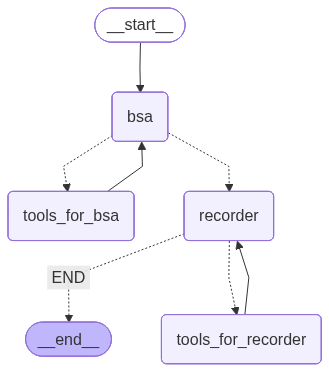

In [14]:
# Step 5: Compile the graph
graph = graph_builder.compile(checkpointer=sql_memory)
display(Image(graph.get_graph().draw_mermaid_png()))

### 5. Test it Out
Use Gradio to create a front end that will allow us to test this out

In [15]:
user_input = """
Create requirements for a website that will track automobile information.  
It should track from the time of purchase, track all mileage, fuel, insurance, registration, repairs and any other associated costs.
"""

# Do NOT USE

# 1. **User Roles**: This site is intended for individual car owners as a personal site with only a handful of users.
# 2. **Data Entry**: Users will manually enter the data through appropriate screens.
# 3. **Reports**: Should just include a single report that list all information about a single vechicle.
# 4. **Mobile Access**: The site should be mobile friendly so that it can be displayed in a phone's browser
# 5. **Integration**: There are no integrations needed.
# 6. **User Notifications**: There should be no user notifications or alerts at this time.
# 7. **Vehicle Information**: The following should be tracked: make, model, year, color, VIN, license plate number, purchase date, purchase price, who it was bought from and when applicable, when it was sold, sold price, and who it was sold to.
# 8. **Cost Tracking**: Cost tracking should include: fuel, insurance, registration, repairs, car washes, accessories, and a miscellaneous categetory that can take in a user note.
# 9. **User Authentication**: The site will initially be available to everyone with full access
# 10. **Data Security**: There any no specific security requirements or considerations for protecting the data entered by the users.



config = {"configurable": {"thread_id": uuid7()}}

with gradio.Blocks() as demo:
    chatbot = gradio.Chatbot(type="messages")
    user_input_box = gradio.Textbox(value=user_input, label="Message")
    submit_btn = gradio.Button("Send")

    def chat_handler(message, history):
        # Invoke the graph with the user message
        result = graph.invoke({"messages": [{"role": "user", "content": message}]}, config=config)
        last_message = result["messages"][-1]
        
        # Convert the last message to proper format
        if isinstance(last_message, str):
            assistant_message = {"role": "assistant", "content": last_message}
        elif isinstance(last_message, dict):
            assistant_message = last_message
        else:
            # Handle LangChain message objects
            assistant_message = {"role": "assistant", "content": last_message.content}
        
        # Return updated history with both user and assistant messages
        return history + [{"role": "user", "content": message}, assistant_message]

    submit_btn.click(chat_handler, [user_input_box, chatbot], chatbot)

demo.launch()

* Running on local URL:  http://127.0.0.1:7875
* To create a public link, set `share=True` in `launch()`.


/Volumes/Storage/Projects/ai_agents/.venv/lib/python3.13/site-packages/pydantic/v1/main.py:1054: UserWarning: LangSmith now uses UUID v7 for run and trace identifiers. This warning appears when passing custom IDs. Please use: from langsmith import uuid7
            id = uuid7()
Future versions will require UUID v7.
  input_data = validator(cls_, input_data)
